### Object detection performance metrics ###

In [52]:
import os
import ast
import re
import numpy as np
import pandas as pd
import logging
import glob
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import patches

# PyTorch and HuggingFace Transformers
import torch
from torchvision import ops
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData
from detection.detrdataset import get_gpu_info, DetectionDatasetFromDF
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xyxy2xywh, xywh2xyxy, clipxywh
from detection.imageproc import determine_bbox_format
from detection.performance import get_iou

print(f'Project module version: {dt.__version__}')
print(f'PyTorch version:        {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev31+g14d1a25.d20250315
PyTorch version:        2.6.0a0+ecf3bae40a.nv25.01


In [15]:
# Check GPU availability
device, device_str = get_gpu_info()

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.6.0a0+ecf3bae40a.nv25.01
CUDA version:      12.8
CUDNN version:     90700


### Helper functions ###

In [24]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, colors=None, ax=None):
    if colors is None:
        color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
        color_list = [color[c] for c in range(len(color))]
    else:
        assert len(colors)==len(box_list), f'Number of colors does not match number bounding boxes.'
        color_list = colors.copy()
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        boxcolor = color_list[b]
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

In [25]:
# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'dentex_detection')
image_dir = os.path.join(data_dir, 'quadrants')

# Model directory
model_name = 'rtdetr_250311_06'
model_dir = os.path.join(data_dir, 'models', model_name)

# Log file
log_file_name = 'train_log_250311.log'
log_file = os.path.join(model_dir, log_file_name)

# Output for the images with the predictions
output_dir = os.path.join(model_dir, 'testresults')
Path(output_dir).mkdir(parents=True, exist_ok=True)

dataset_df_file_name = 'train_split_250224.parquet'
dataset_df_file = os.path.join(image_dir, dataset_df_file_name)
df = pd.read_parquet(dataset_df_file)
display(df.head(2))

# convert class id to ada position
ada_list = sorted(list(df['ada'].unique()))
id2label = dict(zip(range(len(ada_list)), ada_list))
label2id = {v: k for k, v in id2label.items()}

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8,train
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7,train


In [26]:
# Load the log file
with open(log_file, mode='r') as fl:
    log = fl.read()
print(log)

250311-21:25-__main__-INFO-{"output_dir": "/app/data/dentex_detection/model/rtdetr_250311_06", "num_train_epochs": 500, "max_grad_norm": 0.1, "learning_rate": 1e-05, "warmup_steps": 300, "per_device_train_batch_size": 48, "dataloader_num_workers": 8, "metric_for_best_model": "eval_map", "greater_is_better": true, "load_best_model_at_end": true, "eval_strategy": "epoch", "save_strategy": "epoch", "save_total_limit": 5, "remove_unused_columns": false, "eval_do_concat_batches": false}
250311-21:25-__main__-INFO-{"model_version": 6, "model_name": "rtdetr_250311_06", "hf_checkpoint": "PekingU/rtdetr_v2_r101vd", "use_transform": "transform_1"}



In [27]:
# Load the model from checkpoint
hf_model_name = 'PekingU/rtdetr_v2_r101vd'
processor = RTDetrImageProcessor.from_pretrained(hf_model_name)
checkpoint_name = 'checkpoint-10140'
checkpoint_file = os.path.join(model_dir, checkpoint_name)
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint_file).to(device)

### Ground truth bounding boxes ###

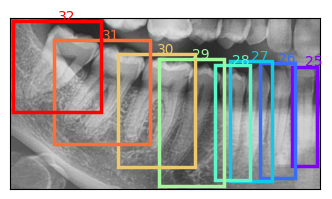

In [94]:
image_idx = 3
figsize = (4, 4)
file_name = df.loc[df['dset'] == 'test', 'file_name'].unique()[image_idx]
file_base_name = os.path.splitext(file_name)[0]
file = os.path.join(image_dir, file_name)
df_file = df.loc[df['file_name'] == file_name]

# Load the image
im = ImageData().load_image(file)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

box_list = df_file['bbox'].to_list()
ada_list = df_file['ada'].to_list()
box_list = [clipxywh(list(box), xlim=xlim, ylim=ylim, decimals=0) for box in box_list]

# Show the image
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=box_list, 
                           label_list=ada_list, 
                           alpha=1, 
                           ax=ax)
plt.show()

### Predicted bounding boxes ###

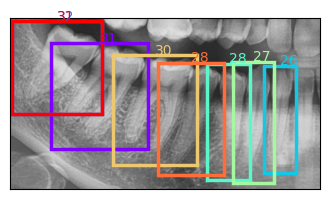

In [95]:
# Process the image to create the input for the model
im_input = processor(im, return_tensors='pt').to(device)
# Run the image through the model
with torch.no_grad():
    model_output = model(**im_input)
# Post-processing: Non-Maximum Suppression (NMS)
threshold = 0.2
results = processor.post_process_object_detection(model_output, 
                                                  target_sizes=torch.tensor([(im.shape[0], im.shape[1])]), 
                                                  threshold=threshold)

output_boxes = results[0].get('boxes').cpu().numpy()
output_boxes = [clipxywh(xyxy2xywh(list(box)), xlim=xlim, ylim=ylim, decimals=0) for box in output_boxes]
output_scores = results[0].get('scores').cpu().numpy()
output_scores = [np.round(score, decimals=3) for score in output_scores]
output_ids = results[0].get('labels').cpu().numpy()
output_ada = [id2label.get(i) for i in output_ids]

# Plot the image with the predicted bounding boxes
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=output_boxes, 
                           label_list=output_ada, 
                           alpha=1, 
                           ax=ax)

### Intersection Over Union IoU ###

Predicted labels: [26, 27, 28, 28, 30, 31, 31, 32]

Predicted label: 31
Predicted score: 0.824999988079071
Predicted bbox:  [124, 77, 294, 321]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.1772995543421528
Torch IoU: tensor([[0.1757]])


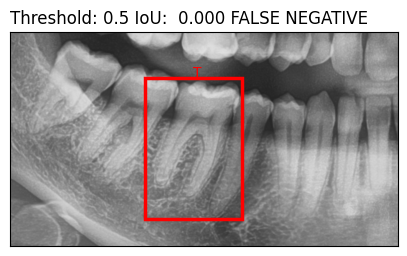

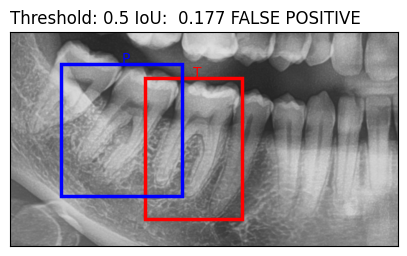


Predicted label: 32
Predicted score: 0.7239999771118164
Predicted bbox:  [7, 11, 272, 281]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.0
Torch IoU: tensor([[0.]])


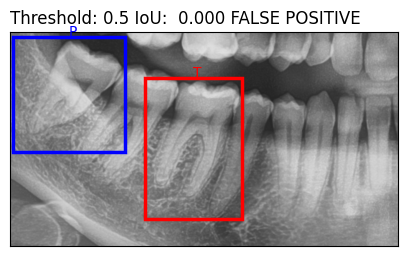


Predicted label: 26
Predicted score: 0.5569999814033508
Predicted bbox:  [769, 146, 100, 324]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.0
Torch IoU: tensor([[0.]])


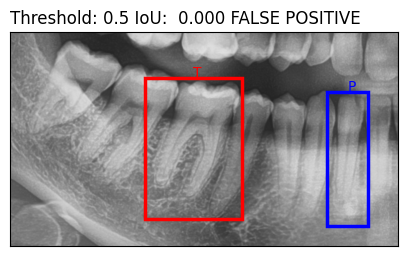


Predicted label: 28
Predicted score: 0.48399999737739563
Predicted bbox:  [599, 140, 130, 351]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.0
Torch IoU: tensor([[0.]])


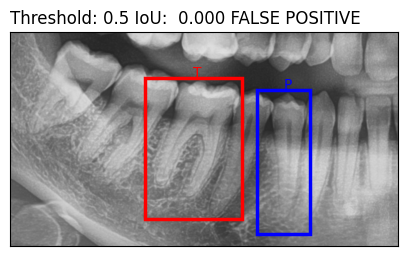


Predicted label: 27
Predicted score: 0.4830000102519989
Predicted bbox:  [675, 133, 126, 367]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.0
Torch IoU: tensor([[0.]])


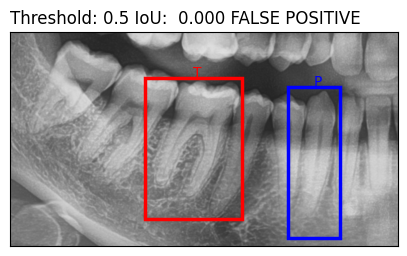


Predicted label: 30
Predicted score: 0.43700000643730164
Predicted bbox:  [312, 113, 255, 335]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.9045033535611625
Torch IoU: tensor([[0.9042]])


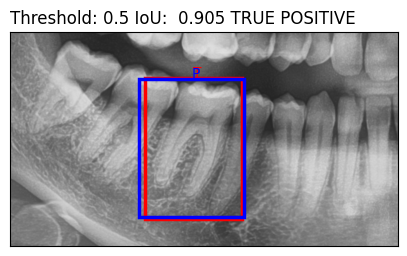


Predicted label: 28
Predicted score: 0.257999986410141
Predicted bbox:  [450, 136, 198, 341]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.31779750955143626
Torch IoU: tensor([[0.3159]])


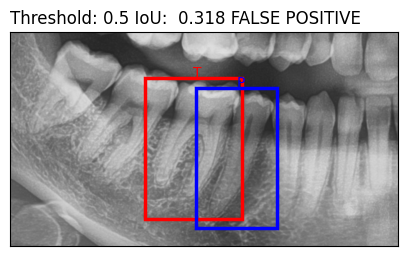


Predicted label: 31
Predicted score: 0.2240000069141388
Predicted bbox:  [7, 11, 272, 281]

True label:     30
True bbox:      [327, 111, 235, 342]
Numpy IoU: 0.0
Torch IoU: tensor([[0.]])


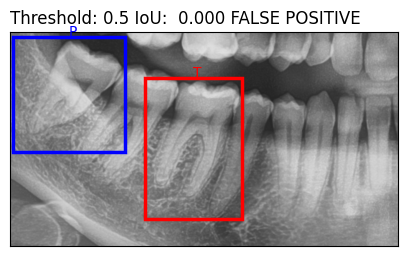

In [96]:
predicted_labels = sorted(output_ada)
print(f'Predicted labels: {predicted_labels}')
figsize = (5, 5)
threshold = 0.5

# Pick the ground truth bounding box
# Ground truth index
tidx = 5
true_label = ada_list[tidx]
true_bbox = box_list[tidx]

# Draw a false negative (no bounding box predicted)
output_file_name = f'{file_base_name}_T{str(true_label).zfill(2)}P_NONE.png'
output_file = os.path.join(output_dir, output_file_name)
plot_box_list = [true_bbox]
plot_lab_list = ['T']
plot_color_list = ['r']
corr = 'FALSE NEGATIVE'
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=plot_box_list, 
                           label_list=plot_lab_list,
                           colors=plot_color_list,
                           alpha=1, 
                           ax=ax)

ax.set_title(f'Threshold: {threshold} IoU: {numpy_iou: .3f} {corr}', loc='left')
plt.savefig(output_file, bbox_inches='tight')

# Select a predicted bounding box
# cl = 30
# pidx = output_ada.index(cl)
for pidx in range(len(output_boxes)):

    pred_label = output_ada[pidx]
    pred_bbox = output_boxes[pidx]
    
    pred_score = output_scores[pidx]
    print()
    print(f'Predicted label: {pred_label}')
    print(f'Predicted score: {pred_score}')
    print(f'Predicted bbox:  {pred_bbox}')
    
    print()
    print(f'True label:     {true_label}')
    print(f'True bbox:      {true_bbox}')
    
    # Calculate the IoU for the two bounding boxes
    numpy_iou = get_iou(bbox_1=true_bbox, bbox_2=pred_bbox, bbox_format='xywh')
    # Determine CORRECTNESS OF PREDICTION
    if numpy_iou >= threshold:
        corr = 'TRUE POSITIVE'
    else:
        corr = 'FALSE POSITIVE'
        
    # PyTorch calculation
    torch_pred_bbox = torch.tensor([xywh2xyxy(pred_bbox)], dtype=torch.float)
    torch_true_bbox = torch.tensor([xywh2xyxy(true_bbox)], dtype=torch.float)
    
    torch_iou = ops.box_iou(torch_true_bbox, torch_pred_bbox)
    print(f'Numpy IoU: {numpy_iou}')
    print(f'Torch IoU: {torch_iou}')
    
    # Let's plot the two bounding boxes 
    output_file_name = f'{file_base_name}_T{str(true_label).zfill(2)}P{str(pred_label).zfill(2)}.png'
    output_file = os.path.join(output_dir, output_file_name)
    plot_box_list = [true_bbox, pred_bbox]
    plot_lab_list = ['T', 'P']
    plot_color_list = ['r', 'b']
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = show_image_with_boxes(image=im, 
                               box_list=plot_box_list, 
                               label_list=plot_lab_list,
                               colors=plot_color_list,
                               alpha=1, 
                               ax=ax)
    ax.set_title(f'Threshold: {threshold} IoU: {numpy_iou: .3f} {corr}', loc='left')
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

Calculate TP, FP and FN for each class separately
Calculate precision and recall

Note that True Negative is not applicable to object detection and segmentation. It is correctly detecting the background of an object as background. Which is equivalent to not detecting anything.

- True Positive: 
    The model predicted that a bounding box exists at a certain position (positive) and it was correct (true)

- False Positive: 
    The model predicted that a bounding box exists at a particular position (positive) but it was wrong (false)

- False Negative:
    The model did not predict a bounding box at a certain position (negative) and it was wrong (false)
    i.e. a ground truth bounding box existed at that position.

- True Negative:
    The model did not predict a bounding box (negative) and it was correct (true).
    This corresponds to the background, the area without bounding boxes,
    and is not used to calculate the final metrics.


A prediction is said to be correct if the class label of the predicted bounding box and the ground truth bounding box is the same and the IoU between them is greater than a threshold value.